In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
# ! unzip ./gdrive/MyDrive/rsna/rsna-pneumonia-detection-challenge.zip -d ./gdrive/MyDrive/rsna/input

In [ ]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! mkdir ./gdrive/MyDrive/rsna
# ! kaggle competitions download -c rsna-pneumonia-detection-challenge -p ./gdrive/MyDrive/rsna

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.6 MB/s 


In [4]:
import os
import sys
import random
import pydicom
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.models import Model
from keras import layers
from keras.layers import Conv2D, Activation, Input, UpSampling2D, concatenate, BatchNormalization
from keras.layers import LeakyReLU
from keras.initializers import RandomNormal

import csv
import pandas as pd
from skimage import io
from skimage import measure
from skimage.transform import resize

from matplotlib import pyplot as plt
import matplotlib.patches as patches

## Model

In [5]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.99999)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D((2, 2))(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9999)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9999)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9999)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

## Data Set

In [6]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join('./gdrive/MyDrive/rsna/input/stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

In [8]:
# load and shuffle filenames
folder = './gdrive/MyDrive/rsna/input/stage_2_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
print(len(filenames))

15240


In [9]:
# split into train and validation filenames
n_train_samples = int(len(filenames) * 0.6)
n_test_samples = int(len(filenames) * 0.2)

train_filenames = filenames[:n_train_samples]
test_filenames = filenames[-n_test_samples:]
valid_filenames = filenames[n_train_samples: -n_test_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
print('n test samples', len(test_filenames))

n train samples 9144
n valid samples 3048
n test samples 3048


In [10]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in self.pneumonia_locations:
            # loop through pneumonia
            for location in self.pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [11]:
# create train and validation generators
folder = './gdrive/MyDrive/rsna/input/stage_2_train_images'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=False, predict=False)
test_gen = generator(folder, test_filenames, pneumonia_locations, batch_size=1, image_size=256, shuffle=False, predict=False)

## Visualization

In [ ]:
iterator = iter(train_gen)
img, msk = next(iterator)

In [ ]:
img = np.squeeze(img[1, :, :, :], axis=2)
msk = np.squeeze(msk[1, :, :, :], axis=2)

In [ ]:
img.shape

(256, 256)

Text(0.5, 1.0, 'Mask')

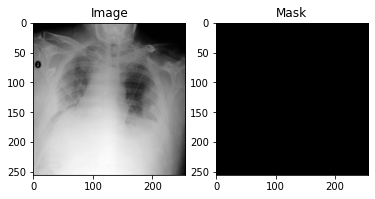

In [ ]:
fig, (axs1, axs2) = plt.subplots(1, 2)
axs1.imshow(img, cmap='gray')
axs1.set_title('Image')
axs2.imshow(msk * img, cmap='gray')
axs2.set_title('Mask')

## Train the model

In [ ]:
OUT_DIM = (256, 256)
# use the predefined depths
nf_enc=[16,32,32,32]
nf_dec=[32,32,32,32,32,16,16,2]

In [ ]:
# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 25
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
model = create_network(input_size=256, channels=32, n_blocks=2, depth=4)

In [ ]:
model.compile(optimizer='adam',
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

In [ ]:
history = model.fit(train_gen, validation_data=valid_gen, callbacks=[learning_rate, early_stopping], epochs=25, workers=4, use_multiprocessing=True)

Epoch 1/25
285/285 [==============================] - 1251s 4s/step - loss: 0.6931 - accuracy: 0.9734 - mean_io_u: 0.4867 - val_loss: 0.6931 - val_accuracy: 0.9739 - val_mean_io_u: 0.4870 - lr: 0.0010
Epoch 2/25
285/285 [==============================] - 1300s 5s/step - loss: 0.6931 - accuracy: 0.9735 - mean_io_u: 0.4868 - val_loss: 0.6931 - val_accuracy: 0.9739 - val_mean_io_u: 0.4870 - lr: 9.9606e-04
Epoch 3/25
285/285 [==============================] - 1247s 4s/step - loss: 0.6931 - accuracy: 0.9735 - mean_io_u: 0.4867 - val_loss: 0.6931 - val_accuracy: 0.9739 - val_mean_io_u: 0.4870 - lr: 9.8429e-04
Epoch 4/25
285/285 [==============================] - 1248s 4s/step - loss: 0.6931 - accuracy: 0.9735 - mean_io_u: 0.4868 - val_loss: 0.6931 - val_accuracy: 0.9739 - val_mean_io_u: 0.4870 - lr: 9.6489e-04
Epoch 5/25
285/285 [==============================] - 1303s 5s/step - loss: 0.6931 - accuracy: 0.9735 - mean_io_u: 0.4867 - val_loss: 0.6931 - val_accuracy: 0.9739 - val_mean_io_u: 0.4

In [ ]:
np.save('./gdrive/MyDrive/my_history.npy', history.history)

In [ ]:
import pandas as pd

pd.DataFrame.from_dict(history_model_1.history).to_csv('history.csv',index=False)

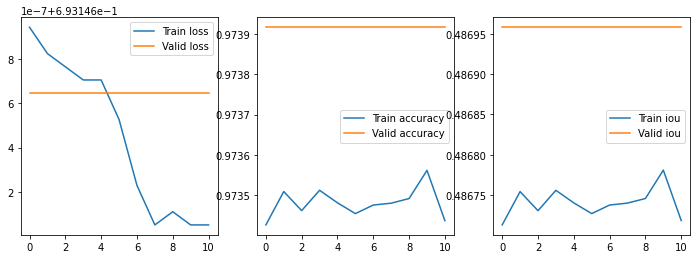

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_io_u"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_io_u"], label="Valid iou")
plt.legend()
plt.show()

In [ ]:
model.save_weights('./gdrive/MyDrive/rnsa/pretrained_model/mskrnn')

## Test Model

In [12]:
new_model = create_network(input_size=256, channels=32, n_blocks=2, depth=4)
new_model.load_weights('./gdrive/MyDrive/rnsa/pretrained_model/mskrnn')
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  288         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [13]:
# loop through testset
res = []
for img, mask in test_gen:
  # predict batch of images
  preds = new_model.predict(img)
  comp = preds[:, :, 0] > 0.5
  miou = tf.keras.metrics.MeanIoU(num_classes=2)
  miou.update_state(preds, mask)
  res.append(miou.result().numpy())

In [14]:
from statistics import mean
mean(res)

0.8792299